In [373]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import scipy.signal
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset
from visual_behavior.ophys.response_analysis.utilities import get_trace_around_timepoint,get_nearest_frame
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis
#drive_path = '/data/dynamic-brain-workshop/visual_behavior'

import oBehave.helperfunctions as obhf
# load manifest
manifest = obhf.load_manifest()
dataset= VisualBehaviorOphysDataset(experiment_id=639438856, cache_dir=obhf.drive_path)
respset = ResponseAnalysis(dataset)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
loading trial response dataframe
loading flash response dataframe


In [321]:
def dffBlockPlot(dff,tme,starttme,framerate = 31,window = (-.5,.75),startstop = (0,.25),
                 ax = None,cmap = 'plasma', returnMatrix = False,aspect = 'auto',
                 plotme = True,xlabel = 'Time',ylabel = 'Flash #'):
    '''
    Plots a block dff block plot. 
    Each plotted row represents a single time series (usually a dff trace)
    locked to the starttime and plotted w.in the specified window.
    Inputs
    dff: 1 D time series
    tme: 1 D time series (same size as dff)
    starttme: "trial" start markers
    framerate: 31 (optional), should be frame rate of time series
    window: (-.5,.75) (optional), 
    ax: None (optional), axis to plot on. If not passed, will use gca
    cmap: 'plasma'(optional), colormap
    returnMatrix: False (optional), Default is to return ax. If True, returns ax AND analyis matrix
    plotme: True (optional), option to skip plotting. If true, output will be ONLY analysis matrix
    aspect: 'auto' (optional), input to imshow to specify axis filling 
    xlabel: 'Time' (optional)
    ylabel = 'Flash #' (optional)
    '''
    # Confirm that the window variable is suitable
    window = np.array(window)
    assert window.ndim==1 
    assert len(window) == 2
    
    # if user did not specify an axis, get one.
    if ax is None:
        ax = plt.gca();
        
    # Construct matrix
    window_size = int(np.abs(window[0])*framerate)+int(np.abs(window[1])*framerate)+1
    X = np.zeros([len(starttme),window_size])

    for ii,ts in enumerate(starttme):
        if ((ts+window[0]>tme[0])&(ts+window[1]<tme[-1])):
            ts_idx = get_nearest_frame(ts,tme)
            X[ii,:] = get_trace_around_timepoint(tme[ts_idx],dff,tme,window,framerate)[0]
        
    # plot and return
    if plotme:
        ax.imshow(X,cmap = cmap,aspect = aspect,extent=[window[0],window[1],0,len(X[:,0])-1])  
        #ax.invert_yaxis()
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if startstop:
            ax.axvline(startstop[0],color = 'cyan')
            ax.axvline(startstop[1],color = 'magenta')

    else:
        return X
    if returnMatrix:
        return ax
    else:
        return X,ax
    
def dffBlockPlot_flashes_allImages(dff,tme,FlashDataFrame,framerate = 31,window = (-.5,.75),
                 fig = None,cmap = 'plasma',aspect = 'auto',
                 xlabel = 'Time',ylabel = 'Flash #'):
    '''
    Wrapper on dffBlockPlot to plot block plots for each image.
    See dffBlockPlot for unspecified documentation
    Inputs
    dff: 1 D time series
    tme: 1 D time series (same size as dff)
    FlashDataFrame: DataFrame in format of DataFrame 
        from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset.VisualBehaviorOphysDataset
    '''
    # Confirm that the window variable is suitable
    window = np.array(window)
    assert window.ndim==1 
    assert len(window) == 2
    
    # if user did not specify an axis, get one.
    if fig is None:
        fig = plt.figure();
    unique_images = np.unique(FlashDataFrame.image_name)
    # make subplots
    ax = fig.subplots(2,len(unique_images)/2)
    ax = ax.flatten()
    
    # plot responce to each image
    for ii, axis in enumerate(ax):
        starttme = FlashDataFrame[FlashDataFrame.image_name==unique_images[ii]].start_time.values
        dffBlockPlot(dff,tme,starttme,ax = axis,framerate = framerate,
                     window = window,cmap = cmap,aspect = aspect,
                     xlabel = xlabel,ylabel = ylabel);
        axis.set_title(unique_images[ii])
    fig.tight_layout()
    
    return fig

def plotMeanFlashResponseOverTime(flash_response_df,cellnumber,ax = None):
    if ax is None:
        ax = plt.gca()
    
    unique_images = np.unique(flash_response_df['image_name'])
    for ii,image in enumerate(unique_images):
        this_responce= flash_response_df[(flash_response_df['image_name']==image)&(flash_response_df['cell']==cellnumber)]['mean_response'].values
        this_frm_idx = flash_response_df[(flash_response_df['image_name']==image)&(flash_response_df['cell']==cellnumber)]['flash_number'].values
        ax.plot(this_frm_idx,this_responce,'.')
    ax.legend(unique_images)

In [353]:
import os
def load_dff_events_file(expt_id):
    #load visual behavior event files by supplying experiment id 
    event_drive_path = '/data/dynamic-brain-workshop/visual_behavior_events' #AWS
    tmp = os.path.join(event_drive_path, str(expt_id)+'_events.npz')
    print(tmp)
    tmp_data = np.load(tmp)
    print(tmp_data)
    event_array = tmp_data['ev']
    return event_array

/data/dynamic-brain-workshop/visual_behavior_events/639438856_events.npz


(0, 1000)

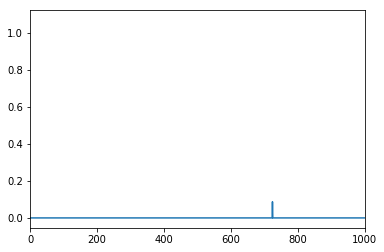

In [362]:
evt = np.array(load_dff_events_file(639438856))
plt.plot(evt[2,:])
plt.xlim([0,1000])

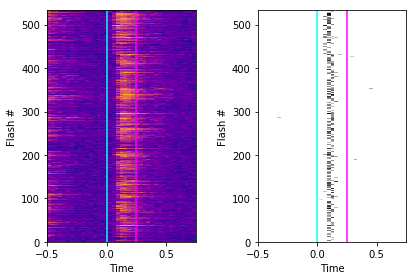

<Figure size 432x288 with 0 Axes>

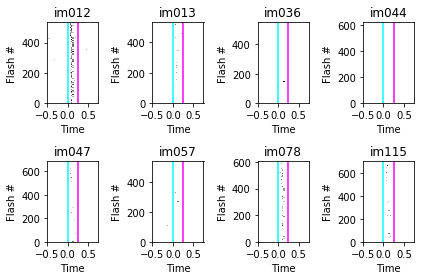

In [371]:
st = dataset.stimulus_table
dff = dataset.dff_traces[19,:]
ev = evt[19,:]
sttmp = st[st['image_name']=='im012'].start_time.values
fig = plt.figure()
axx = fig.subplots(1,2)
dffBlockPlot(dff,tme,sttmp,ax = axx[0])
dffBlockPlot(ev,tme,sttmp,cmap = 'binary',ax = axx[1])
fig.tight_layout()
fig = plt.figure()
dffBlockPlot_flashes_allImages(ev,tme,st,cmap = 'binary');
#plt.figure()
#plotMeanFlashResponseOverTime(respset.flash_response_df,19);


(0, 2000)

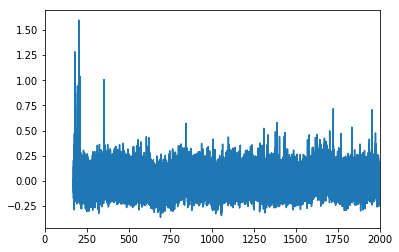

In [330]:
plt.plot(tme,dff)
plt.xlim(0,2000)

In [ ]:
378